Prepare audioset

In [1]:
import pandas as pd

datapath = "/data/lujd/algorithm2022/audioset/"
train_df = pd.read_csv(datapath+"train.csv", sep="\t")
dev_df = pd.read_csv(datapath+"dev.csv", sep="\t")
eval_df = pd.read_csv(datapath+"eval.csv", sep="\t")

unique_labels = ['airport', 'bus', 'metro', 'metro_station',
                'park', 'public_square', 'shopping_mall',
                'street_pedestrian', 'street_traffic', 'tram']
label_dict = {}
for ind, c in enumerate(unique_labels):
    label_dict[c] = ind

n_mels = 40
feature_option = "mfcc"

Train

In [2]:
# extract feature
import numpy as np
from Extract_feature import extract_mfcc

# train set
train_files = list(train_df.filename)
train_labels = list(train_df.scene_label)
train_features = []
for filename in train_files:
    wav_file_path = datapath+filename
    mfcc_feature = extract_mfcc(wav_file_path, n_mels=n_mels, option=feature_option)
    train_features.append(mfcc_feature.reshape(1,-1))           # [1, frames*n_features] (flatten)
train_features = np.concatenate(train_features, axis=0)
print(f"train feature size: {train_features.shape}")

# dev set
dev_files = list(dev_df.filename)
dev_labels = list(dev_df.scene_label)
dev_features = []
for filename in dev_files:
    wav_file_path = datapath+filename
    mfcc_feature = extract_mfcc(wav_file_path, n_mels=n_mels, option=feature_option)
    dev_features.append(mfcc_feature.reshape(1,-1))             # [1, frames*n_features] (flatten)
dev_features = np.concatenate(dev_features, axis=0)
print(f"dev feature size: {dev_features.shape}")

train feature size: (3008, 6487)
dev feature size: (379, 6487)


In [3]:
# train
from sklearn.cluster import KMeans

model_km1 = KMeans(n_clusters=len(unique_labels), max_iter=1, random_state=0).fit(train_features)

# get each class's mean feature for cluster center
start_pos, end_pos = 0, 0
for ind, c in enumerate(unique_labels):
    target_df = train_df[train_df.scene_label==c]
    end_pos += len(target_df)
    # print(start_pos, end_pos)
    model_km1.cluster_centers_[ind] = np.mean(train_features[start_pos:end_pos,:], axis=0)
    start_pos = end_pos

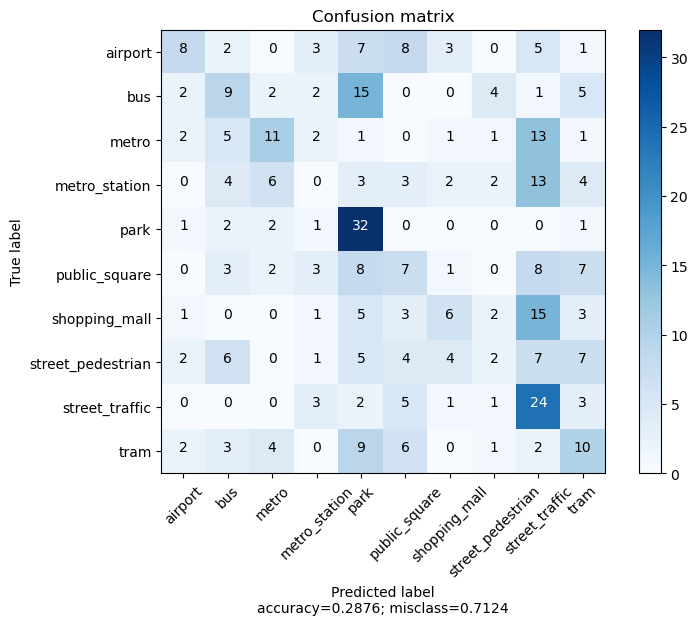

In [4]:
# dev
from sklearn.metrics import confusion_matrix
from utils import plot_confusion_matrix

dev_labels = [label_dict[c] for c in dev_labels]
dev_pre_labels = model_km1.predict(dev_features)
dev_true_labels = np.asarray(dev_labels)
dev_cm = confusion_matrix(dev_true_labels, dev_pre_labels)
# dev_cm_df = pd.DataFrame(dev_cm, columns=label_dict.keys(), index=label_dict.keys())
# dev_cm_df
plot_confusion_matrix(dev_cm, label_dict.keys())

In [5]:
dev_acc_df = pd.DataFrame()
for c, i in label_dict.items():
    acc = dev_cm[i,i] / np.sum(dev_cm[i])
    dev_acc_df[c] = [acc]
dev_acc_df["all"] = np.trace(dev_cm) / float(np.sum(dev_cm))
dev_acc_df.rename(index={0: "accurary"})
dev_acc_df

,airport,bus,metro,metro_station,park,public_square,shopping_mall,street_pedestrian,street_traffic,tram,all
0,0.216216,0.225,0.297297,0.0,0.820513,0.179487,0.166667,0.052632,0.615385,0.27027,0.287599


Test on eval set

In [6]:
# extract feature
import numpy as np
from Extract_feature import extract_mfcc

eval_files = list(eval_df.filename)
eval_labels = list(eval_df.scene_label)
eval_features = []
for filename in eval_files:
    wav_file_path = datapath+filename
    mfcc_feature = extract_mfcc(wav_file_path, n_mels=n_mels, option=feature_option)
    eval_features.append(mfcc_feature.reshape(1,-1))             # [1, frames*n_features] (flatten)
eval_features = np.concatenate(eval_features, axis=0)
print(f"dev feature size: {eval_features.shape}")

dev feature size: (330, 6487)


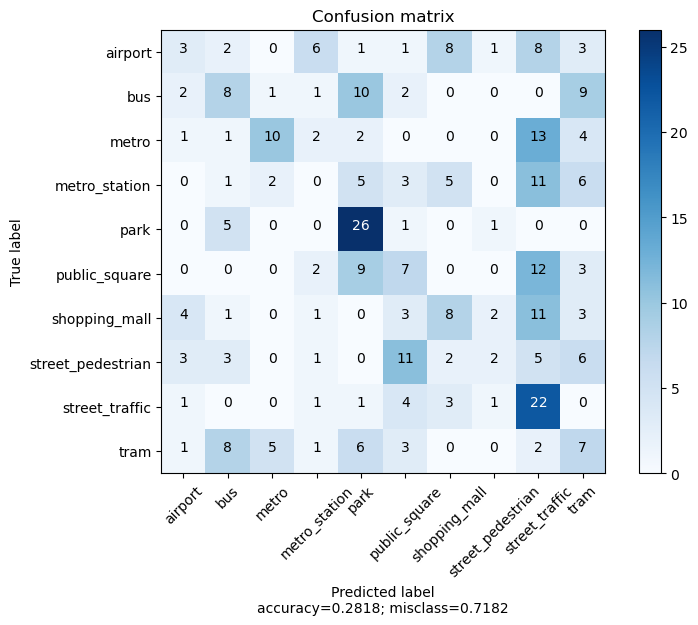

In [7]:
from sklearn.metrics import confusion_matrix
from utils import plot_confusion_matrix

eval_labels = [label_dict[c] for c in eval_labels]
eval_pre_labels = model_km1.predict(eval_features)
eval_true_labels = np.asarray(eval_labels)
eval_cm = confusion_matrix(eval_true_labels, eval_pre_labels)
# eval_cm_df = pd.DataFrame(eval_cm, columns=label_dict.keys(), index=label_dict.keys())
# eval_cm_df
plot_confusion_matrix(eval_cm, label_dict.keys())

In [8]:
eval_acc_df = pd.DataFrame()
for c, i in label_dict.items():
    acc = eval_cm[i,i] / np.sum(eval_cm[i])
    eval_acc_df[c] = [acc]
eval_acc_df["all"] = np.trace(eval_cm) / float(np.sum(eval_cm))
eval_acc_df.rename(index={0: "accurary"})
eval_acc_df

,airport,bus,metro,metro_station,park,public_square,shopping_mall,street_pedestrian,street_traffic,tram,all
0,0.090909,0.242424,0.30303,0.0,0.787879,0.212121,0.242424,0.060606,0.666667,0.212121,0.281818
